# Metabolite Identifier Alignment AI with LoRA Fine-tuning

## 1. Setup

In [ ]:
import os
import torch
import torch.nn.functional as F
import time  
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz, process
import psutil
import os
import json
from sklearn.model_selection import train_test_split
import re
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AdamW
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
import random
from transformers import BertTokenizer,AutoModel, AutoTokenizer

In [ ]:
import json
processed_data= []
with open('training_data.jsonl', 'r') as f:
    for line in f:
        processed_data.append(json.loads(line))


## Load Training Data

In [ ]:
class MetaboliteContrastiveDataset(Dataset):
   """Dataset for contrastive learning with metabolite pairs"""
   
   def __init__(self, data, tokenizer, max_length=64):
       self.data = data
       self.tokenizer = tokenizer
       self.max_length = max_length
   
   def __len__(self):
       return len(self.data)
   
   def __getitem__(self, idx):
       item = self.data[idx]
       
       # Tokenize both metabolites
       tokens1 = self.tokenizer(
           item["metabolite1"],
           max_length=self.max_length,
           padding="max_length",
           truncation=True,
           return_tensors="pt"
       )
       
       tokens2 = self.tokenizer(
           item["metabolite2"],
           max_length=self.max_length,
           padding="max_length",
           truncation=True,
           return_tensors="pt"
       )
       
       return {
           "input_ids1": tokens1["input_ids"].squeeze(),
           "attention_mask1": tokens1["attention_mask"].squeeze(),
           "input_ids2": tokens2["input_ids"].squeeze(),
           "attention_mask2": tokens2["attention_mask"].squeeze(),
           "label": torch.tensor(item["label"], dtype=torch.float)
       }


## Define Model Architecture

In [ ]:
class MetaboliteContrastiveModel(nn.Module):
   """Model for metabolite contrastive learning with LoRA"""
   
   def __init__(self, model_name="EMBO/BioMegatron345mUncased"):
       super().__init__()
       # Load base model
       self.encoder = AutoModel.from_pretrained(model_name)
       
       # Apply LoRA
       lora_config = LoraConfig(
           r=16,                               # Low rank
           lora_alpha=32,                      # Scaling factor
           target_modules=["query", "key", "value", "dense"],  # Target attention layers
           lora_dropout=0.1,
       )
       self.encoder = get_peft_model(self.encoder, lora_config)
   
   def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
       # Get embeddings for both metabolites
       outputs1 = self.encoder(input_ids=input_ids1, attention_mask=attention_mask1)
       outputs2 = self.encoder(input_ids=input_ids2, attention_mask=attention_mask2)
       
       # Extract CLS token embeddings
       emb1 = outputs1.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
       emb2 = outputs2.last_hidden_state[:, 0, :]
       
       return emb1, emb2


In [ ]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:

def contrastive_loss(emb1, emb2, labels, margin=0.5):
   """
   Contrastive loss function
   
   Args:
       emb1, emb2: Embeddings for metabolite pairs
       labels: 1 for positive pairs, 0 for negative pairs
       margin: Minimum separation for negative pairs
   """
   # Compute cosine similarity
   similarity = F.cosine_similarity(emb1, emb2, dim=1)
   
   # Convert to distance (1 - similarity)
   distance = 1 - similarity
   
   # Contrastive loss
   positive_loss = labels * (distance ** 2)
   negative_loss = (1 - labels) * torch.clamp(margin - distance, min=0.0) ** 2
   
   loss = positive_loss + negative_loss
   return loss.mean()

def train_contrastive_model(processed_data, epochs=10, batch_size=16, learning_rate=2e-4):
   """
   Train the metabolite contrastive model with LoRA
   
   Args:
       processed_data: Output from preprocess_metabolite_data()
       epochs: Number of training epochs
       batch_size: Training batch size
       learning_rate: Learning rate for optimizer
   """
   # Setup device
   device = torch.device("cuda")
   
   # Initialize tokenizer and model
   tokenizer = BertTokenizer.from_pretrained("EMBO/BioMegatron345mUncased")
   model = MetaboliteContrastiveModel().to(device)
   
   # Setup dataset and dataloader
   dataset = MetaboliteContrastiveDataset(processed_data, tokenizer)
   dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
   
   # Setup optimizer (only LoRA parameters are trainable)
   optimizer = AdamW(model.parameters(), lr=learning_rate)

   # Initialize loss tracking
   train_losses = []  # Average loss per epoch
   batch_losses = []  # Loss per batch
    
   # Training loop
   model.train()
   for epoch in range(epochs):
       print(epoch)
       total_loss = 0
       
       for batch in dataloader:
           # Move batch to device
           batch = {k: v.to(device) for k, v in batch.items()}
           
           # Forward pass
           emb1, emb2 = model(
               batch["input_ids1"], batch["attention_mask1"],
               batch["input_ids2"], batch["attention_mask2"]
           )
           
           # Compute contrastive loss
           loss = contrastive_loss(emb1, emb2, batch["label"])
           
           # Backward pass
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()

           batch_loss = loss.item()
           total_loss += loss.item()
           
           batch_losses.append(batch_loss)
           
       avg_loss = total_loss / len(dataloader)
       train_losses.append(avg_loss)
   return model, tokenizer,train_losses,batch_losses

## Training

In [ ]:
# Usage
model_trained, tokenizer,train_losses,batch_losses = train_contrastive_model(processed_data, epochs=10)


Some weights of MegatronBertModel were not initialized from the model checkpoint at EMBO/BioMegatron345mUncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0
1
2
3
4
5
6
7
8
9


### Save Model

In [ ]:
torch.save(model_trained, "./metabolite_lora_model/complete_model.pth")

# Save tokenizer
tokenizer.save_pretrained("./metabolite_lora_model")

('./metabolite_lora_model/tokenizer_config.json',
 './metabolite_lora_model/special_tokens_map.json',
 './metabolite_lora_model/vocab.txt',
 './metabolite_lora_model/added_tokens.json')

### Visualize Training Loss

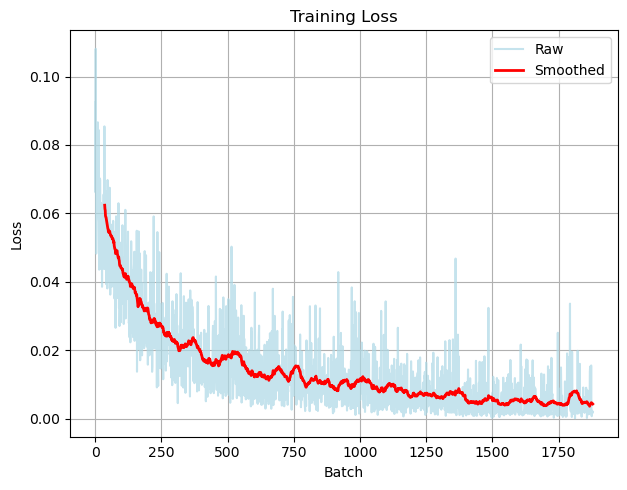

Initial loss: 0.0924
Final loss: 0.0019
Improvement: 98.0%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot batch losses
plt.figure(figsize=(12, 5))

# Raw batch losses
plt.subplot(1, 2, 1)
plt.plot(batch_losses, alpha=0.7, color='lightblue', label='Raw')
# Smoothed trend
window = max(1, len(batch_losses) // 50)
smoothed = np.convolve(batch_losses, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(batch_losses)), smoothed, 'red', linewidth=2, label='Smoothed')
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()

print(f"Initial loss: {batch_losses[0]:.4f}")
print(f"Final loss: {batch_losses[-1]:.4f}")
print(f"Improvement: {(batch_losses[0] - batch_losses[-1])/batch_losses[0]*100:.1f}%")

## Testing

In [ ]:
bigg_mets=pd.read_excel('bigg_mets.xlsx')
mets_test=pd.read_excel('mets_test_prepared.xlsx')

In [ ]:
metNames=mets_test['metNames'].copy()
matched_name=mets_test['BiGG_name'].copy()
bigg_names=bigg_mets['name'].copy()
bigg_list = bigg_names.dropna().tolist()
for i in range(len(metNames)):
    if pd.isna(matched_name.iloc[i]):
        query_metabolite = metNames.iloc[i]
        top_3_fuzzy = process.extract(
            query_metabolite, 
            bigg_list,  # This contains all BiGG names already
            scorer=fuzz.ratio,
            limit=3
        )
        matched_name.iloc[i] = top_3_fuzzy

### Base Model

In [ ]:
checkpoint = "EMBO/BioMegatron345mUncased"
# The tokenizer. Megatron was trained with standard tokenizer(s).
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = AutoModel.from_pretrained(checkpoint)
device = torch.device("cuda:0") 
model = model.to(device)

Some weights of MegatronBertModel were not initialized from the model checkpoint at EMBO/BioMegatron345mUncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def similarity_calculator(met1,met2):
    tokens1 = tokenizer(met1, return_tensors="pt").to(device)
    tokens2 = tokenizer(met2, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs1 = model(**tokens1)
        outputs2 = model(**tokens2)
    cls_emb1 = outputs1.last_hidden_state[:, 0, :]
    cls_emb2 = outputs2.last_hidden_state[:, 0, :]
    result=F.cosine_similarity(cls_emb1, cls_emb2).item()
    return result
    
# Test with your metabolites
met1 = "1-hexadecanoylsn-glycerol 3phosphate"
met2 = "1-hexadecanoylsn-glycerol-3phosphate"
similarity_calculator(met1,met2)

0.9974626302719116

In [ ]:
neural_scores = pd.Series(index=range(len(metNames)), dtype=float)  # Pre-initialize list

for i in range(len(metNames)):
    if isinstance(matched_name.iloc[i], list):  # Check if it's fuzzy results
        query_metabolite = metNames.iloc[i]
        fuzzy_results = matched_name.iloc[i]
        
        best_score = 0
        best_match = None
        
        for candidate_name, fuzzy_score in fuzzy_results:
            neural_score = similarity_calculator(query_metabolite, candidate_name)  # Fix: define neural_score
            neural_scores[i] = neural_score  # Fix: use neural_score, not neural_scores[i] 
            
            if neural_score > best_score:  # Fix: use neural_score
                best_score = neural_score
                best_match = candidate_name
        
        matched_name.iloc[i] = best_match
        
    elif pd.notna(matched_name.iloc[i]):  # Single match case
        neural_scores[i] = similarity_calculator(metNames.iloc[i], matched_name.iloc[i])  # Fix: [i] not [o]

In [ ]:
mets_test['matched_base_model']=matched_name
mets_test['neural_scores_base_model']=neural_scores 
base_model_classification=(neural_scores > 0.94).astype(int)
mets_test['base_model_classification']=base_model_classification

In [ ]:
mets_test.to_excel('mets_test_base.xlsx', index=False)

### Fine-tuned Model

In [ ]:
from peft import PeftModel
device = torch.device("cuda")

In [ ]:
trained_model = torch.load("./metabolite_lora_model/complete_model.pth", 
                   map_location=device, weights_only=False)

In [ ]:
trained_model = trained_model.to(device)

In [ ]:
def similarity_calculator_trained(met1, met2):
    # Tokenize both metabolites
    tokens1 = tokenizer(met1, max_length=64, padding="max_length", 
                       truncation=True, return_tensors="pt")
    tokens2 = tokenizer(met2, max_length=64, padding="max_length", 
                       truncation=True, return_tensors="pt")
    
    # Move to device
    input_ids1 = tokens1["input_ids"].to(device)
    attention_mask1 = tokens1["attention_mask"].to(device)
    input_ids2 = tokens2["input_ids"].to(device)
    attention_mask2 = tokens2["attention_mask"].to(device)
    
    with torch.no_grad():
        # Use the model's forward method correctly
        emb1, emb2 = trained_model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        # Calculate cosine similarity
        similarity = torch.cosine_similarity(emb1, emb2, dim=1)
    return similarity.cpu().item()

In [ ]:
neural_scores = pd.Series(index=range(len(metNames)), dtype=float)  # Pre-initialize list

for i in range(len(metNames)):
    if isinstance(matched_name.iloc[i], list):  # Check if it's fuzzy results
        query_metabolite = metNames.iloc[i]
        fuzzy_results = matched_name.iloc[i]
        
        best_score = 0
        best_match = None
        
        for candidate_name, fuzzy_score in fuzzy_results:
            neural_score = similarity_calculator_trained(query_metabolite, candidate_name)  # Fix: define neural_score
            neural_scores[i] = neural_score  # Fix: use neural_score, not neural_scores[i] 
            
            if neural_score > best_score:  # Fix: use neural_score
                best_score = neural_score
                best_match = candidate_name
        
        matched_name.iloc[i] = best_match
        
    elif pd.notna(matched_name.iloc[i]):  # Single match case
        neural_scores[i] = similarity_calculator_trained(metNames.iloc[i], matched_name.iloc[i])  # Fix: [i] not [o]

In [ ]:
mets_test['matched_trained_model']=matched_name
mets_test['neural_scores_trained_model']=neural_scores 
trained_model_classification=(neural_scores > 0.94).astype(int)
mets_test['trained_model_classification']=trained_model_classification

In [ ]:
mets_test.to_excel('mets_test_trained.xlsx', index=False)

### Result

In [ ]:
mets_test_base=pd.read_excel('mets_test_base.xlsx')

In [ ]:
base_accuracy=sum(mets_test_base['groundTrueLabel']==mets_test_base['base_model_classification'])/len(mets_test_base['groundTrueLabel'])
print("base_accuracy, ",base_accuracy)

base_accuracy,  0.5037037037037037


In [ ]:
mets_test_trained=pd.read_excel('mets_test_trained.xlsx')

In [ ]:
trained_accuracy=sum(mets_test_trained['groundTrueLabel']==mets_test_trained['trained_model_classification'])/len(mets_test_trained['groundTrueLabel'])
print("trained_accuracy, ",trained_accuracy)

trained_accuracy,  0.7555555555555555


In [ ]:
# Base model false positives
fp_indices_base = mets_test_base[
      (mets_test_base['groundTrueLabel'] == 0) &
      (mets_test_base['base_model_classification'] == 1)
  ].index.tolist()

  # Base model false negatives
fn_indices_base = mets_test_base[
      (mets_test_base['groundTrueLabel'] == 1) &
      (mets_test_base['base_model_classification'] == 0)
  ].index.tolist()

  # Trained model false positives
fp_indices_trained = mets_test_trained[
      (mets_test_trained['groundTrueLabel'] == 0) &
      (mets_test_trained['trained_model_classification'] == 1)
  ].index.tolist()

  # Trained model false negatives
fn_indices_trained = mets_test_trained[
      (mets_test_trained['groundTrueLabel'] == 1) &
      (mets_test_trained['trained_model_classification'] == 0)
  ].index.tolist()

In [ ]:
print(f"Base model - False Positive indices: {len(fp_indices_base)} samples")
print(f"Base model - False Negative indices: {len(fn_indices_base)} samples")
print(f"Trained model - False Positive indices: {len(fp_indices_trained)} samples")
print(f"Trained model - False Negative indices: {len(fn_indices_trained)} samples")

Base model - False Positive indices: 62 samples
Base model - False Negative indices: 5 samples
Trained model - False Positive indices: 24 samples
Trained model - False Negative indices: 9 samples


### Export corrected cases

In [ ]:
corrected_fp_base = mets_test_base[
      (mets_test_base['groundTrueLabel'] == 0) &
      (mets_test_base['base_model_classification'] == 1) &
      (mets_test_trained['trained_model_classification'] == 0)
  ][['metNames', 'matched_base_model', 'groundTrueLabel', 'neural_scores_base_model']]

corrected_fp_trained = mets_test_trained.loc[corrected_fp_base.index, ['neural_scores_trained_model']]
corrected_fp = pd.concat([corrected_fp_base, corrected_fp_trained], axis=1)

corrected_fn_base = mets_test_base[
      (mets_test_base['groundTrueLabel'] == 1) &
      (mets_test_base['base_model_classification'] == 0) &
      (mets_test_trained['trained_model_classification'] == 1)
  ][['metNames', 'matched_base_model', 'groundTrueLabel', 'neural_scores_base_model']]

corrected_fn_trained = mets_test_trained.loc[corrected_fn_base.index, ['neural_scores_trained_model']]
corrected_fn = pd.concat([corrected_fn_base, corrected_fn_trained], axis=1)

with pd.ExcelWriter('corrected_cases.xlsx', engine='openpyxl') as writer:
      corrected_fp.to_excel(writer, sheet_name='Corrected_FP', index=True)
      corrected_fn.to_excel(writer, sheet_name='Corrected_FN', index=True)